# Loading bakage

In [1]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

%matplotlib inline
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K 
import random
import urllib.request
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, LSTM, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0  # Import EfficientNet
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import datetime

from skimage.filters import rank, threshold_otsu
from skimage import io
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import img_to_array
from keras.utils import np_utils
from sklearn.datasets import load_files   
from tqdm import tqdm
from collections import Counter
from skimage.morphology import closing, square, disk
#to see full text:
pd.set_option("display.max_colwidth", 1)
from termcolor import colored
print(colored("\nNECESSARY LIBRARIES WERE SUCCESFULLY IMPORTED...", color = "green", attrs = ["bold", "dark"]))


NECESSARY LIBRARIES WERE SUCCESFULLY IMPORTED...


# Loading Data

In [2]:
dataset_path_train = os.listdir('C:\\Users\\abhikamuni\\Downloads\\Project\\eye-diseases-classification\\dataset')
print (dataset_path_train)
print("Types of classes labels found: ", len(dataset_path_train))

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Types of classes labels found:  4


In [3]:
class_label = []

for item in dataset_path_train: 
 #
 all_classes = os.listdir('C:\\Users\\abhikamuni\\Downloads\\Project\\eye-diseases-classification\\dataset\\' + '\\' +item+'\\')
 # Add them to the list
 for room in all_classes:
    class_label.append((item, str('C:\\Users\\abhikamuni\\Downloads\\Project\\eye-diseases-classification\\dataset\\' + item) + '\\' + room))


# Extracting labels and file paths into separate lists
labels = [label for label, _ in class_label]
file_paths = [file_path for _, file_path in class_label]

# Creating DataFrame
df = pd.DataFrame({'Labels': labels, 'image': file_paths})

In [4]:
# This Parameter we can use it in the network and model
batch_size = 32
img_height = 256
img_width = 256

# Load and preprocess data
data_dir = "C:\\Users\\abhikamuni\\Downloads\\Project\\eye-diseases-classification\\dataset"
class_labels = []
image_paths = []

for item in os.listdir(data_dir):
    item_dir = os.path.join(data_dir, item)
    if os.path.isdir(item_dir):
        for filename in os.listdir(item_dir):
            if filename.endswith(".jpg"):
                class_labels.append(item)
                image_paths.append(os.path.join(item_dir, filename))

df = pd.DataFrame({"Labels": class_labels, "image": image_paths})


In [5]:
df.head()

,Labels,image
0,cataract,C:\Users\abhikamuni\Downloads\Project\eye-diseases-classification\dataset\cataract\0_left.jpg
1,cataract,C:\Users\abhikamuni\Downloads\Project\eye-diseases-classification\dataset\cataract\103_left.jpg
2,cataract,C:\Users\abhikamuni\Downloads\Project\eye-diseases-classification\dataset\cataract\1062_right.jpg
3,cataract,C:\Users\abhikamuni\Downloads\Project\eye-diseases-classification\dataset\cataract\1083_left.jpg
4,cataract,C:\Users\abhikamuni\Downloads\Project\eye-diseases-classification\dataset\cataract\1084_right.jpg


In [6]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df["image"], df["Labels"], test_size=0.2, random_state=42)


In [7]:
from sklearn.preprocessing import LabelEncoder
# One-hot encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
num_classes = len(label_encoder.classes_)
y_train_encoded = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_val_encoded = tf.keras.utils.to_categorical(y_val_encoded, num_classes)


In [8]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import load_img


# Load images and convert them to arrays
def load_images(image_paths, img_height=256, img_width=256):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        images.append(img_array)
    return np.array(images)

X_train_cnn = load_images(X_train)
X_val_cnn = load_images(X_val)


In [9]:
# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [10]:
train_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='image',
    y_col='Labels',
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

Found 4217 validated image filenames belonging to 4 classes.


# Creat Model

In [11]:
input_shape=(256,256,3)
batch_size=64
classes=4

In [12]:
from tensorflow.keras.applications import DenseNet121

# Load DenseNet121 model
densenet = tf.keras.applications.DenseNet121(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

In [13]:
# Fine-tuning
for layer in densenet.layers:
    layer.trainable = False


In [14]:
# Define CNN model
cnn_output = densenet.output
cnn_output = Flatten()(cnn_output)


In [15]:
from tensorflow.keras.layers import Input, Dense, LSTM, Reshape
from tensorflow.keras.layers import Dense, Flatten, Input, LSTM, Reshape, concatenate

# Define the RNN part with LSTM
rnn_input = Input(shape=(512,))  # Assuming this is the output shape from the CNN
reshaped_rnn_input = Reshape((1, 512))(rnn_input)  # Reshape for LSTM compatibility
rnn_output = LSTM(64)(reshaped_rnn_input)

In [16]:
from tensorflow.keras.layers import concatenate
# Combine both models
combined_model = concatenate([cnn_output, rnn_output])



In [17]:
# Add output layer
output = Dense(num_classes, activation='softmax')(combined_model)


In [18]:
# Create the combined model
model = Model(inputs=[densenet.input, rnn_input], outputs=output)


In [19]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
patience = 1
stop_patience = 3
factor = 0.5
#tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
# Define callbacks for training
callbacks = [
    ModelCheckpoint("abhi_model.h5", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

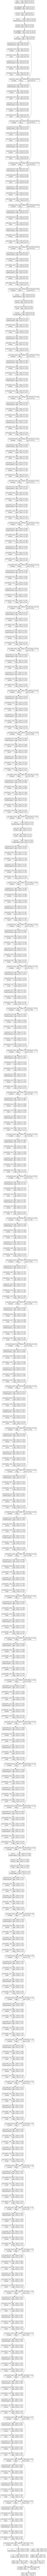

In [21]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='cnn-plant.png', show_shapes=True)

In [22]:
# Train the model
model.fit([X_train_cnn, np.zeros((len(X_train_cnn), 512))], y_train_encoded, 
          validation_data=([X_val_cnn, np.zeros((len(X_val_cnn), 512))], y_val_encoded), 
          batch_size=64, epochs=10, callbacks=callbacks)

Epoch 1/10
53/53 [==============================] - ETA: 0s - loss: 3.1049 - accuracy: 0.7338 
Epoch 1: val_loss improved from inf to 1.78529, saving model to abhi_model.h5
53/53 [==============================] - 1042s 19s/step - loss: 3.1049 - accuracy: 0.7338 - val_loss: 1.7853 - val_accuracy: 0.8424 - lr: 0.0010
Epoch 2/10
53/53 [==============================] - ETA: 0s - loss: 0.6342 - accuracy: 0.8912 
Epoch 2: val_loss improved from 1.78529 to 0.85727, saving model to abhi_model.h5
53/53 [==============================] - 926s 18s/step - loss: 0.6342 - accuracy: 0.8912 - val_loss: 0.8573 - val_accuracy: 0.8246 - lr: 0.0010
Epoch 3/10
53/53 [==============================] - ETA: 0s - loss: 0.5708 - accuracy: 0.8965 
Epoch 3: val_loss improved from 0.85727 to 0.76252, saving model to abhi_model.h5
53/53 [==============================] - 906s 17s/step - loss: 0.5708 - accuracy: 0.8965 - val_loss: 0.7625 - val_accuracy: 0.8768 - lr: 0.0010
Epoch 4/10
53/53 [======================

In [23]:
from tensorflow.keras.preprocessing import image
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder

class_label = []

for item in dataset_path_train: 
 #
 all_classes = os.listdir('C:\\Users\\abhikamuni\\Downloads\\Project\\eye-diseases-classification\\dataset\\' + '\\' +item+'\\')
 # Add them to the list
 for room in all_classes:
    class_label.append((item, str('C:\\Users\\abhikamuni\\Downloads\\Project\\eye-diseases-classification\\dataset\\' + item) + '\\' + room))


# Extracting labels and file paths into separate lists
labels = [label for label, _ in class_label]
file_paths = [file_path for _, file_path in class_label]

# Creating DataFrame
df = pd.DataFrame({'Labels': labels, 'image': file_paths})
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df["image"], df["Labels"], test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
num_classes = len(label_encoder.classes_)
y_train_encoded = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_val_encoded = tf.keras.utils.to_categorical(y_val_encoded, num_classes)



model = load_model('abhi_model.h5')
# Load the image for prediction
img_path = r"C:\Users\abhikamuni\Downloads\Project\eye-diseases-classification\dataset\diabetic_retinopathy\10680_right.jpeg"
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize the image array

# Expand dimensions to match the input shape expected by the model
img_array = np.expand_dims(img_array, axis=0)

# Prepare the RNN input (all zeros since we're not using RNN)
rnn_input = np.zeros((img_array.shape[0], 512))

# Make prediction
prediction = model.predict([img_array, rnn_input])

# Decode the prediction
predicted_class_index = np.argmax(prediction)
predicted_class = label_encoder.classes_[predicted_class_index]

print("Predicted class:", predicted_class)


1/1 [==============================] - 4s 4s/step
Predicted class: diabetic_retinopathy


In [24]:
from flask import Flask, render_template, request, redirect, url_for
from werkzeug.utils import secure_filename
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from keras.models import load_model

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = r'C:/Users/abhikamuni/Downloads/Project/eye-diseases-classification/static/uploads'

# Load the trained model
model = load_model('C:\\Users\\abhikamuni\\Downloads\\Project\\eye-diseases-classification\\abhi_model.h5')  # Update with the path to your trained model

def predict_eye_disease(img_path):
    # Load the image for prediction
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image array

    # Expand dimensions to match the input shape expected by the model
    img_array = np.expand_dims(img_array, axis=0)

    # Prepare the RNN input (all zeros since we're not using RNN)
    rnn_input = np.zeros((img_array.shape[0], 512))

    # Make prediction
    prediction = model.predict([img_array, rnn_input])

    # Decode the prediction
    predicted_class_index = np.argmax(prediction)
    # If you have a list of class names, you can directly index it
    class_names = ['cataract',  'diabetic_retinopathy','glaucoma','normal']  # Replace with your class names
    predicted_class = class_names[predicted_class_index]

    return predicted_class, img_array[0]

@app.route('/')
def index():
    return render_template('firstPage.html')

@app.route('/secondPage', methods=['GET', 'POST'])
def second_page():
    if request.method == 'GET':
        return render_template('secondPage.html')
    
    if 'file' not in request.files:
        return redirect(request.url)

    file = request.files['file']

    if file.filename == '':
        return redirect(request.url)

    if file:
        filename = secure_filename(file.filename)
        file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(file_path)

        # Call prediction function
        prediction, uploaded_image = predict_eye_disease(file_path)

        # Delete the uploaded file after processing
        #os.remove(file_path)

        return render_template('secondPage.html', prediction=prediction, uploaded_image=filename)

if __name__ == '__main__':
    port = int(os.environ.get('PORT', 5000))
    app.run(host='0.0.0.0', port=port)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.4:5000
Press CTRL+C to quit
127.0.0.1 - - [04/Apr/2024 11:44:22] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2024 11:44:22] "GET /static/style.css HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2024 11:44:22] "GET /static/project1.jpg HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2024 11:44:22] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [04/Apr/2024 11:44:24] "GET /secondPage HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2024 11:44:24] "GET /static/style2.css HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2024 11:44:24] "GET /static/project1.jpg HTTP/1.1" 304 -


1/1 [==============================] - 7s 7s/step


127.0.0.1 - - [04/Apr/2024 11:44:56] "POST /secondPage HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2024 11:44:56] "GET /static/style2.css HTTP/1.1" 304 -
127.0.0.1 - - [04/Apr/2024 11:44:56] "GET /static/uploads/6_2143075.jpg HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2024 11:52:29] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2024 11:52:29] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [04/Apr/2024 11:52:29] "GET /static/project1.jpg HTTP/1.1" 304 -
127.0.0.1 - - [04/Apr/2024 11:52:32] "GET /secondPage HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2024 11:52:32] "GET /static/style2.css HTTP/1.1" 304 -
127.0.0.1 - - [04/Apr/2024 11:52:32] "GET /static/project1.jpg HTTP/1.1" 304 -


1/1 [==============================] - 0s 317ms/step


127.0.0.1 - - [04/Apr/2024 11:52:47] "POST /secondPage HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2024 11:52:47] "GET /static/uploads/11545_left.jpeg HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2024 11:52:47] "GET /static/style2.css HTTP/1.1" 304 -
